# Introduction to Eureka

Authors: Kevin Stevenson, Laura Kreidberg, Sebastian Zieba 

Eureka is a JWST pipeline

In this notebook, we will cover the installation of the software as well as an example

# Installation

_TODO_ : Install instructions

# Imports
Here are a few basic imports we'll need later on...

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Download the simulated data

https://stsci.app.box.com/s/8r6kqh9m53jkwkff0scmed6zx42g307e/folder/136379342485

This directory containts simulated NIRCam grism time series data. It uses the MIRAGE tool to simulate time series. This includes detector effects (like 1/f noise, amplifier offsets, RC pixels, etc.) from ground-based testing. MIRAGE adds photon noise and cosmic rays. We (the NIRCam instrument team) have modified MIRAGE to include more realizations of the detector noise than in the base version (35 realizations, vs. 5 in base MIRAGE). Note that MIRAGE does not include flat fielding effects (as of late April, 2021) – though the pipeline also does not currently do a flat field correction (the flat reference is blank until we get on-orbit).

### We will work with Stage 2 data.



Stage 2 – For NIRCam, Stage 2 consists of the flat field correction (though see above), WCS/wavelength solution, and photometric calibration (counts/sec -> MJy). Note that this is specifically for NIRCam: the steps in Stage 2 change a bit depending on the instrument. The Stage 2 outputs are rougly equivalent to a “flt” file from HST.

- Stage 2 Outputs/*calints.fits - Fully calibrated images (MJy) for each individual integration. This is the one you want if you’re starting with Stage 2 and want to do your own spectral extraction.
- Stage 2 Outputs/*x1dints.fits - A FITS binary table containing 1D extracted spectra for each integration in the “calint” files.

Here, a WASP-43 b-like planet with artificial spectral features is simulated from the ERS Simulated Spectra Team. The observing mode is as follows:

- GRISMR+F322W2 pupil and filter
- RAPID readout mode
- 19 Groups per integrations
- 1287 integrations
- 1 Exposure
- 4 Output amplifiers

### Read in the fits files

In [326]:
# Set the path where the simulated JWST NIRCam Stage 2 data is saved 
datadir = '/home/zieba/Desktop/Data/JWST_simulated_data_may2021/NIRCam/Stage2/'

# 
suffix = 'calints'  # Data file suffix


segment_list = []
for fname in os.listdir(datadir):
    if fname.endswith(suffix + '.fits'):
        segment_list.append(datadir +'/'+ fname)
        print(fname)
#segment_list = sn.sort_nicely(segment_list)
num_data_files = len(segment_list)
print(f'\nFound {num_data_files} data file(s) ending in {suffix}.fits')


jw00042001001_01101_00002-seg006_nrca5_calints.fits
jw00042001001_01101_00002-seg014_nrca5_calints.fits
jw00042001001_01101_00002-seg003_nrca5_calints.fits
jw00042001001_01101_00002-seg010_nrca5_calints.fits
jw00042001001_01101_00002-seg005_nrca5_calints.fits
jw00042001001_01101_00002-seg001_nrca5_calints.fits
jw00042001001_01101_00002-seg019_nrca5_calints.fits
jw00042001001_01101_00002-seg012_nrca5_calints.fits
jw00042001001_01101_00002-seg021_nrca5_calints.fits
jw00042001001_01101_00002-seg011_nrca5_calints.fits
jw00042001001_01101_00002-seg013_nrca5_calints.fits
jw00042001001_01101_00002-seg009_nrca5_calints.fits
jw00042001001_01101_00002-seg008_nrca5_calints.fits
jw00042001001_01101_00002-seg004_nrca5_calints.fits
jw00042001001_01101_00002-seg007_nrca5_calints.fits
jw00042001001_01101_00002-seg002_nrca5_calints.fits
jw00042001001_01101_00002-seg018_nrca5_calints.fits
jw00042001001_01101_00002-seg016_nrca5_calints.fits
jw00042001001_01101_00002-seg017_nrca5_calints.fits
jw0004200100

Note that the data themselves are divided into “segments,” with each individual segment (seg001, seg002, etc.) containing a subset of the overall dataset. This is how flight data will be delivered. The segments are numbered in their order of observation.

### Header of a fits file

In [327]:
filename = segment_list[8]

In [328]:
filename

'/home/zieba/Desktop/Data/JWST_simulated_data_may2021/NIRCam/Stage2//jw00042001001_01101_00002-seg021_nrca5_calints.fits'

In [329]:
# NIRCam specific rountines go here
import numpy as np
from astropy.io import fits

# Read FITS file from JWST's NIRCam instrument

hdulist = fits.open(filename)

# Load master and science headers
mhdr    = hdulist[0].header
shdr    = hdulist['SCI',1].header

intstart    = mhdr['INTSTART']
intend      = mhdr['INTEND']

data    = hdulist['SCI',1].data
err     = hdulist['ERR',1].data
dq      = hdulist['DQ',1].data
wave    = hdulist['WAVELENGTH',1].data
v0      = hdulist['VAR_RNOISE',1].data
int_times = hdulist['INT_TIMES',1].data[intstart-1:intend]

In [330]:
mhdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2021-04-27T19:31:36.628' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jw00042001001_01101_00002-seg021_nrca5_calints.fits' / Name of the fi
FILETYPE= 'calibrated'         / Type of data in the file                       
CAL_VER = '1.1.1.dev62+ge2a402ac' / Calibration software version number         
CAL_VCS = 'e2a402ac'           / Calibration software version control sys number
DATAMODL= 'SlitModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                            

In [331]:
shdr

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                   64                                                  
NAXIS3  =                    7                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
SRCTYPE = 'POINT   '           / Source type used for calibration               
BUNIT   = 'MJy/sr  '           / physical units of the array values             
                                                                                
        Photometry informati

## Some Notable information from the Header

### physical units of the array values

In [332]:
shdr['BUNIT']

'MJy/sr'

### Determine Source position in slit using the Science Image Header

In [333]:
src_xpos = shdr['SRCXPOS']-xwindow[0]
src_ypos = shdr['SRCYPOS']-ywindow[0]

In [334]:
src_xpos

1480.0

In [335]:
src_ypos

29

# Let's Plot the Science Image

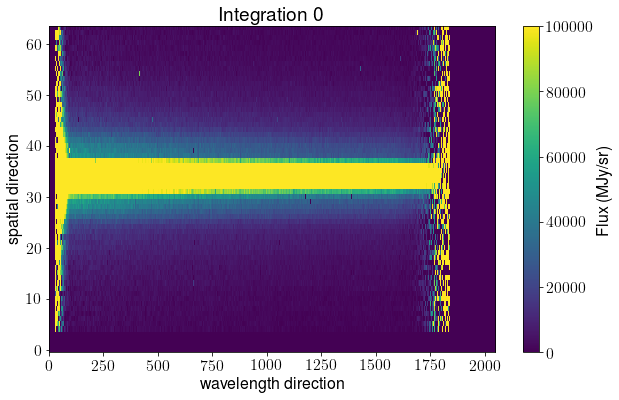

In [336]:
#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(data[0], origin = 'lower', aspect='auto',  vmin=0, vmax=100000)
fig.colorbar(im, label='Flux (MJy/sr)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')
plt.show()
plt.close()

### Remove the edges

In [337]:
xwindow=[100,1700]
ywindow=[5,64]

In [338]:
subdata     = data    [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]

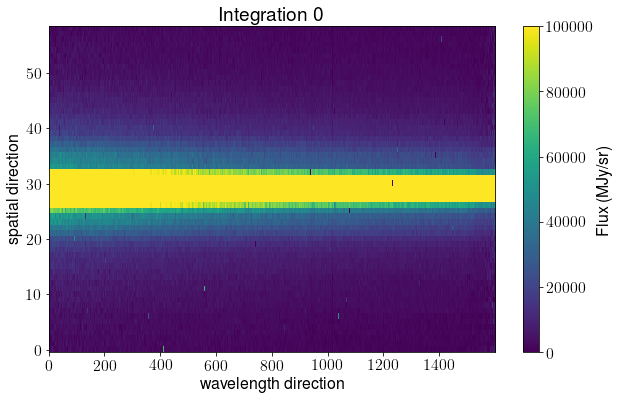

In [339]:
#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0], origin = 'lower', aspect='auto',  vmin=0, vmax=100000)
fig.colorbar(im, label='Flux (MJy/sr)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')
plt.show()
plt.close()

### Let's decide which parts we want to use for the background and for the spectrum

Let's use a +/-20 pixel area around the spectrum in the spatial direction

In [340]:
bg_hw    = 20
spec_hw  = 20

In [341]:
bg_y1   = int(src_ypos - bg_hw)
bg_y2   = int(src_ypos + bg_hw)

In [342]:
ap_y1   = int(src_ypos - spec_hw)
ap_y2   = int(src_ypos + spec_hw)

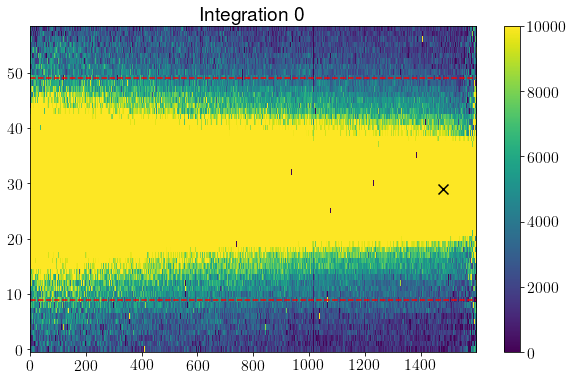

In [343]:

#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0], origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
ax.scatter(src_xpos, src_ypos, marker='x', c='k', s=100)
ax.axhline(bg_y1, c='r', ls='--')
ax.axhline(bg_y2, c='r', ls='--')
fig.colorbar(im)
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
plt.show()
plt.close()

In [344]:
submask = np.zeros(subdata.shape)

submask[:,  :bg_y1] = 1
submask[:,bg_y2:  ] = 1

#mask[:,  :y1] = sigrej.sigrej(bgdata1, bg_thresh, bgmask1, estsig1)
#mask[:,y2:  ] = sigrej.sigrej(bgdata2, bg_thresh, bgmask2, estsig2)

### calculate background in every column

In [345]:
bg = np.array([[np.median(subdata[0, :, i][np.where(submask[0, :, i])])]*59 for i in range(1600)]).T

### subtract background

In [346]:
subdata[0] - bg

array([[ -179.52368 , -1001.3342  ,  2071.745   , ...,  -618.484   ,
        -4116.9365  , 10087.277   ],
       [  825.14526 ,  -742.02075 , -3137.4207  , ...,  4253.333   ,
        -5050.2515  , -2771.9902  ],
       [-1433.0189  , -1673.5522  , -2348.598   , ..., -3036.2886  ,
          353.36633 , -4129.3047  ],
       ...,
       [ 2515.4058  ,  -243.09814 , -2399.6885  , ...,  6258.534   ,
           21.912598,  4357.1357  ],
       [-1616.0828  ,   319.4087  , -2996.701   , ...,  -382.6665  ,
        -3583.1738  ,  3978.7058  ],
       [-1110.8906  ,  2603.5322  ,   235.12622 , ...,  2715.9216  ,
        -5179.6353  , -3432.9348  ]], dtype=float32)

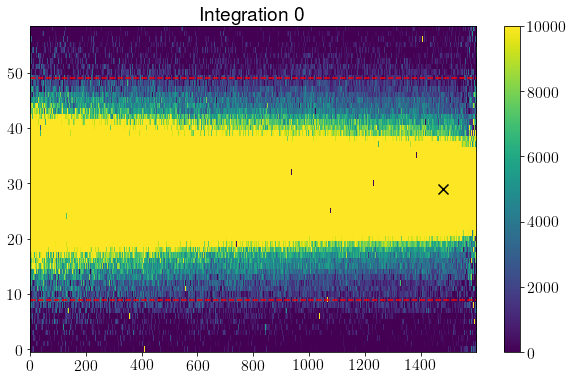

In [347]:
#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0] - bg, origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
#im = ax.imshow(bgdata2[0], origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
ax.scatter(src_xpos, src_ypos, marker='x', c='k', s=100)
ax.axhline(bg_y1, c='r', ls='--')
ax.axhline(bg_y2, c='r', ls='--')
fig.colorbar(im)
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
plt.show()
plt.close()

In [348]:
data_bgcorr = subdata[0] - bg

In [349]:
apdata      = data_bgcorr[ap_y1:ap_y2]
stdspec     = np.sum(apdata, axis=0)

### Plot spectrum

In [350]:
wvl = wave[0][xwindow[0]:xwindow[1]]

Text(0, 0.5, 'Flux (MJr/sr)')

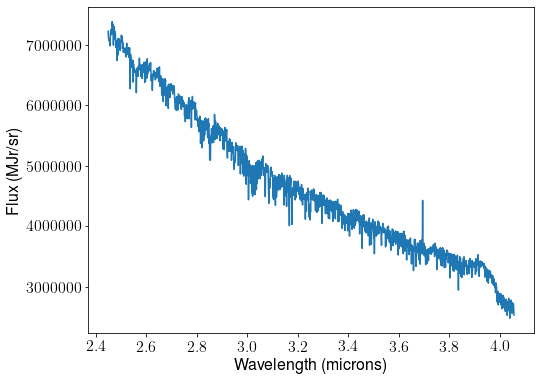

In [351]:
fig, ax=plt.subplots(figsize=(8,6))

ax.plot(wvl, stdspec)
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Flux (MJr/sr)')

# Convert MJr/sr to DN
The detector gain is the ratio of electrons to detector count (typically expressed as data numbers, or DN).

### Is in Eureka

In [352]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [353]:
from eureka.S3_data_reduction import bright2flux

Read data in again

In [354]:
data    = hdulist['SCI',1].data
err     = hdulist['ERR',1].data
wave    = hdulist['WAVELENGTH',1].data
v0      = hdulist['VAR_RNOISE',1].data

subdata     = data    [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]
suberr      = err     [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]
subwave     = wave    [  ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]
subv0       = v0      [:,ywindow[0]:ywindow[1],xwindow[0]:xwindow[1]]

In [355]:
# Convert from brightness units (MJy/sr) to DNs

photfile = '/home/zieba/Desktop/Data/JWST_simulated_data_may2021/NIRCam/ancil/jwst_nircam_photom_0064.fits'

subdata, suberr, subv0 = bright2flux.bright2dn(subdata, suberr, subv0, subwave, photfile, mhdr, shdr)

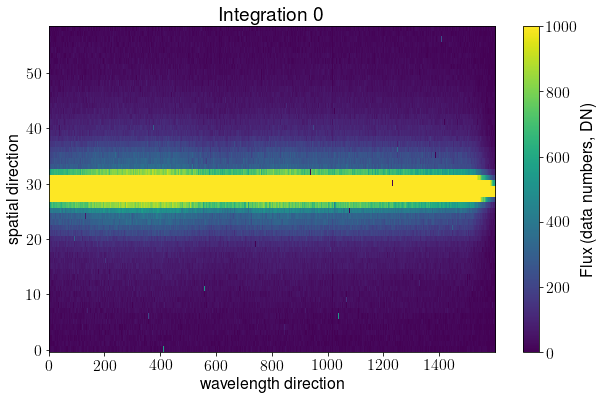

In [356]:
#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0], origin = 'lower', aspect='auto',  vmin=0, vmax=1000)
fig.colorbar(im, label='Flux (data numbers, DN)')
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')
plt.show()
plt.close()

In [357]:
submask = np.zeros(subdata.shape)

submask[:,  :bg_y1] = 1
submask[:,bg_y2:  ] = 1

#mask[:,  :y1] = sigrej.sigrej(bgdata1, bg_thresh, bgmask1, estsig1)
#mask[:,y2:  ] = sigrej.sigrej(bgdata2, bg_thresh, bgmask2, estsig2)

### calculate background in every column

In [358]:
bg = np.array([[np.median(subdata[0, :, i][np.where(submask[0, :, i])])]*59 for i in range(1600)]).T

### subtract background

In [359]:
subdata[0] - bg

array([[ -0.85796833,  -4.8393574 ,  10.085378  , ...,  -0.9917977 ,
         -6.377446  ,  15.092251  ],
       [  3.9434853 ,  -3.5861177 , -15.273149  , ...,   6.8206224 ,
         -7.8232217 ,  -4.14736   ],
       [ -6.8485975 ,  -8.088126  , -11.433114  , ...,  -4.8689766 ,
          0.5473914 ,  -6.1781297 ],
       ...,
       [ 12.021477  ,  -1.1748714 , -11.681826  , ...,  10.036152  ,
          0.03394437,   6.5190024 ],
       [ -7.7234855 ,   1.5436726 , -14.588118  , ...,  -0.613642  ,
         -5.5506067 ,   5.952808  ],
       [ -5.309101  ,  12.582634  ,   1.1446075 , ...,   4.355238  ,
         -8.023646  ,  -5.136244  ]], dtype=float32)

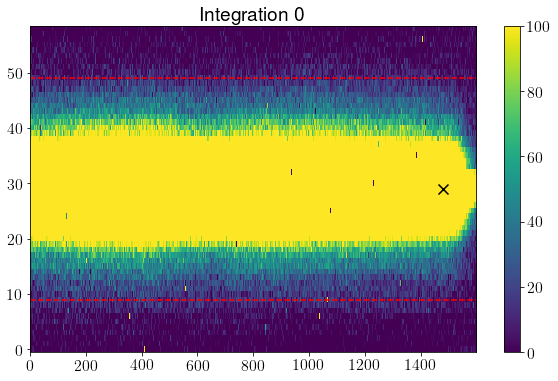

In [361]:
#print(d[1].data)
fig, ax = plt.subplots(1,1,figsize=(10,6))

im = ax.imshow(subdata[0] - bg, origin = 'lower', aspect='auto',  vmin=0, vmax=100)
#im = ax.imshow(bgdata2[0], origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
ax.scatter(src_xpos, src_ypos, marker='x', c='k', s=100)
ax.axhline(bg_y1, c='r', ls='--')
ax.axhline(bg_y2, c='r', ls='--')
fig.colorbar(im)
#plt.tight_layout()
ax.set_title('Integration {0}'.format(0))
plt.show()
plt.close()

In [362]:
data_bgcorr = subdata[0] - bg

In [363]:
apdata      = data_bgcorr[ap_y1:ap_y2]
stdspec     = np.sum(apdata, axis=0)

### Plot spectrum

In [364]:
wvl = wave[0][xwindow[0]:xwindow[1]]

Text(0, 0.5, 'Flux (DN)')

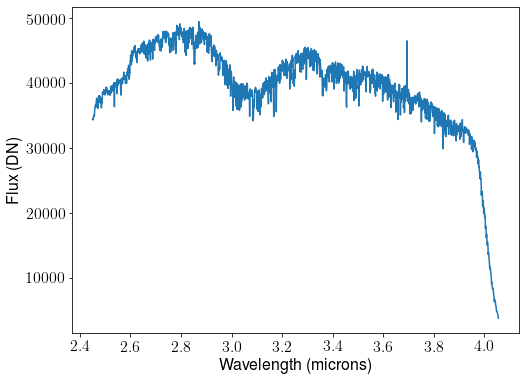

In [366]:
fig, ax=plt.subplots(figsize=(8,6))

ax.plot(wvl, stdspec)
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Flux (DN)')

- barycentric correction

In [69]:
# Target Coordinates
ra  = mhdr['TARG_RA'] * np.pi / 180.0  # stores right ascension
dec = mhdr['TARG_DEC'] * np.pi / 180.0  # stores right ascension

mjdutc = int_times['int_mid_MJD_UTC']
#bjdtdb = int_times['int_mid_BJD_TDB']
bjdtdb = barycorr.to_bjdtdb(ev, mjdutc, m)